# Program Assignment #1 - Naïve Bayes part2 (iris dataset)
---

## Name: 李勝維
## Student ID: 0711239

### Part2 for iris dataset

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Load data

In [3]:
# load iris dataset
raw_data = pd.read_csv('data/iris.data', header=None).values
x, y = raw_data[..., :-1], raw_data[..., -1]

# Data visualization  
畫圖，binning的方式是透過sklearn.preprocessing.KBinsDiscretizer來fit，策略為讓每個bin的寬度是一樣的（uniform）  
每張圖分別代表了三種花在同個feature下的資料分佈

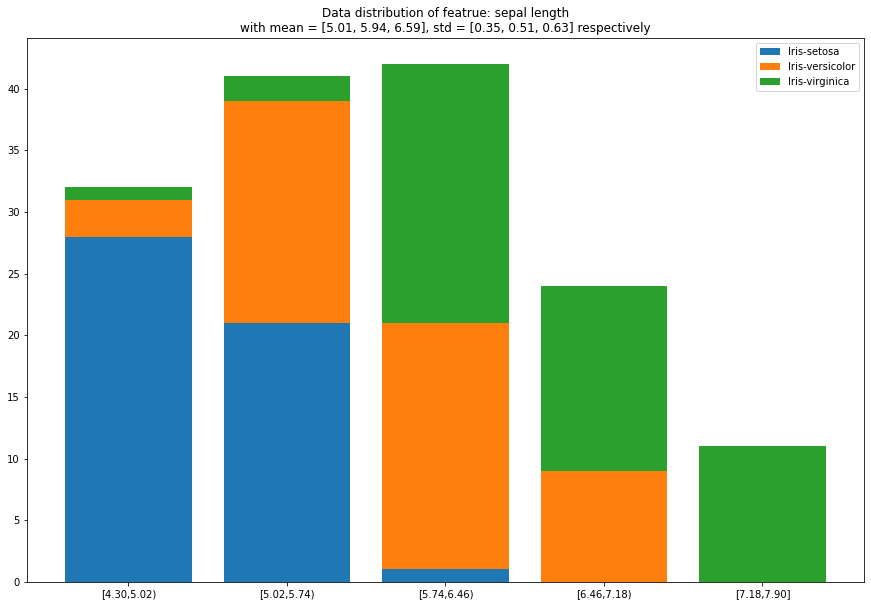

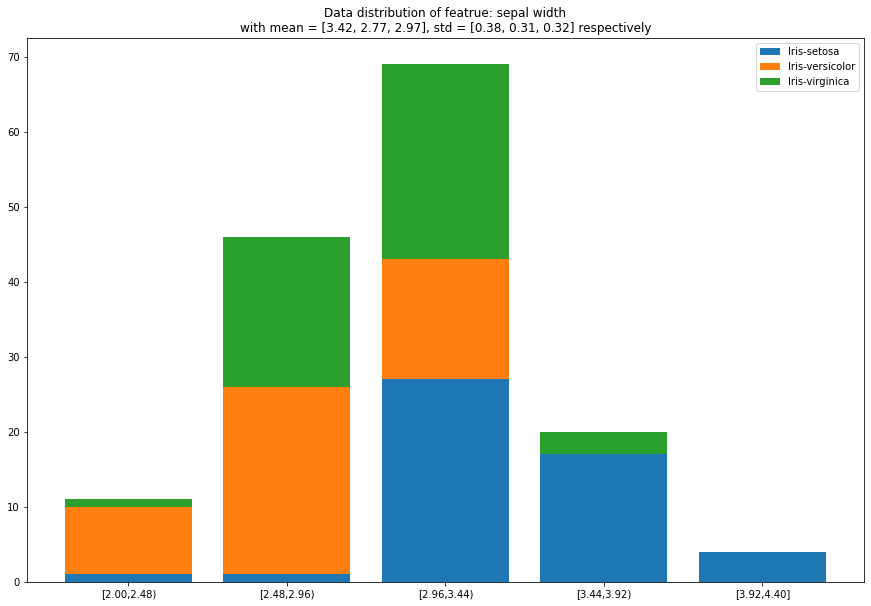

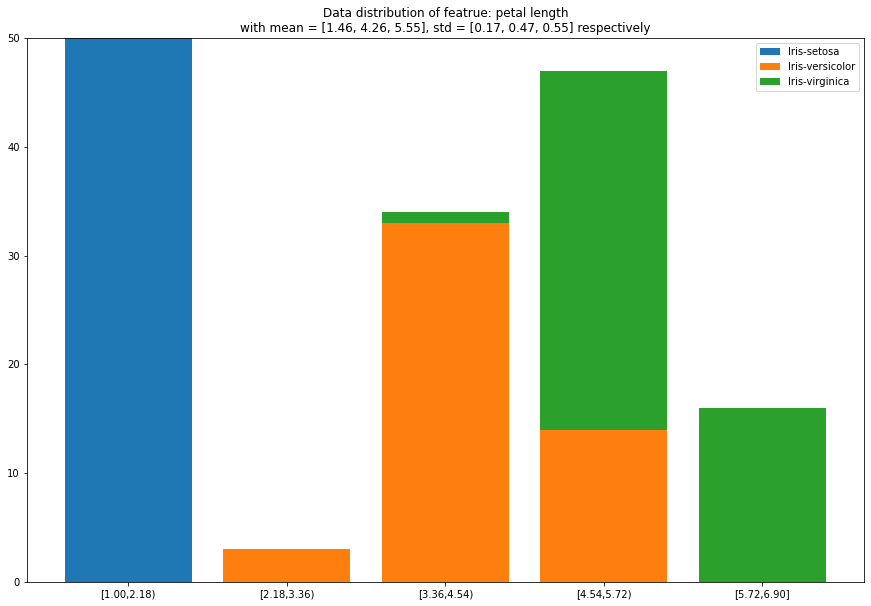

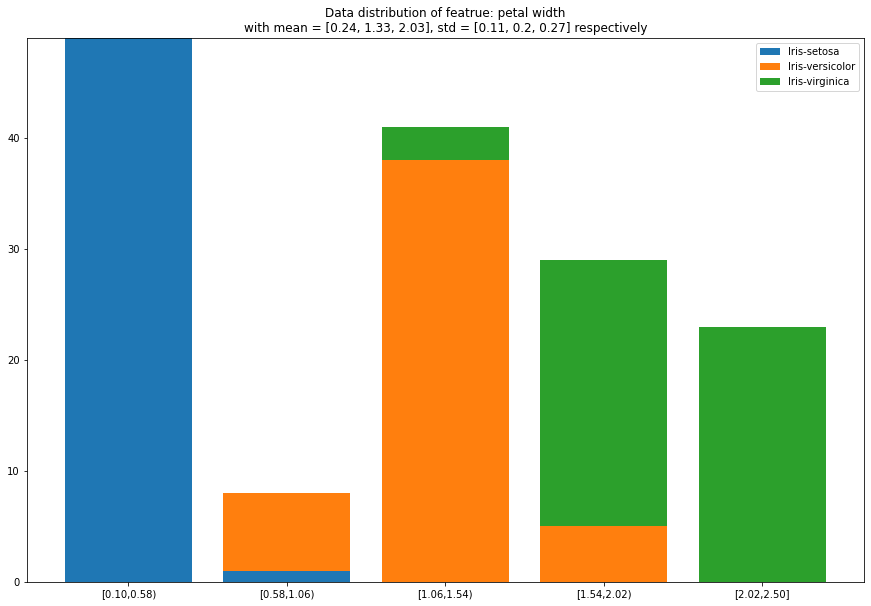

In [4]:
from sklearn.preprocessing import KBinsDiscretizer
feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width']

def merged_plot_distribution(*xs):
    for feature, feature_name in enumerate(feature_names):
        plt.figure(figsize=[15, 10])
        pre = None
        means=list()
        stds=list()
        for (name, x) in xs:
            # get labels of x-axis
            edges = bin.bin_edges_[feature]
            x_ticks = list()
            for i in range(1, len(edges)):
                if i == len(edges)-1:
                    x_ticks.append(f"[{edges[i-1]:.2f},{edges[i]:.2f}]")
                else:
                    x_ticks.append(f"[{edges[i-1]:.2f},{edges[i]:.2f})")

            # calculate means and stds
            means.append(round(np.mean(x[..., feature]), 2))
            stds.append(round(np.std(x[..., feature]), 2))

            # transform values based on bins and count them
            binned = bin.transform(x)
            idx, tmp = np.unique(binned[..., feature], return_counts=True)
            counts = np.zeros(len(x_ticks), dtype='int')
            for i, idxx in enumerate(idx.astype('int')):
                counts[idxx] = tmp[i]

            # plot
            plt.bar(x_ticks, counts, bottom=pre, label=name)
            if pre is None:
                pre = counts
            else:
                pre += counts
        plt.title(f'Data distribution of featrue: {feature_name}\nwith mean = {means}, std = {stds} respectively')
        plt.legend()
    plt.show()

bin = KBinsDiscretizer(5, encode='ordinal', strategy='uniform')
bin.fit(x)
x_S = x[np.where(y=='Iris-setosa')]
x_Ve = x[np.where(y=='Iris-versicolor')]
x_Vi = x[np.where(y=='Iris-virginica')]
merged_plot_distribution(('Iris-setosa', x_S), ('Iris-versicolor', x_Ve), ('Iris-virginica', x_Vi))

# Data preprocessing

In [5]:
# delete columns with '?' value in it
for something_missing in np.unique(np.where(x == '?')[1]):
    x = np.delete(x, something_missing, 1)

# transform label/features from char -> int
from sklearn.preprocessing import LabelEncoder
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

# shuffle data
from sklearn.utils import shuffle
x, y = shuffle(x, y)

# Bonus: extra transforms
透過 normalize each sample，將K fold的 accuracy, sensitivity和precision由原本的(0.96, 0.96, 0.96047)提升至(0.973333, 0.973333, 0.975309)  
有試過不同的seed 都有提升  
推測原因是透過normalization，可以將每個sample的4個feature之間的差異標準化，讓classifier更容易總結出結論

In [6]:
from sklearn.preprocessing import normalize
x = normalize(x, axis=1, norm='l2')

# Model Construction
(clf stands for classifier)  
var_smoothing代表的是將最大的varience的某個比例加到其他項varience，但是作業要求不需要它，所以設為0

In [7]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB(var_smoothing=0)

# Train-Test-Split  
這邊定義了使用 Hold-out 和 Kfold 兩種驗證方法的函數  
透過使用sklearn.metrics中的函數來實作，其中sensitivity和precision是分別求不同class分別當成positive後，取平均值  
最後使用了 tabulate 套件來畫表格

In [8]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tabulate import tabulate

def hold_out(clf,x, y, ratio=(0.7, 0.3)):
    table_data=list()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(ratio[1]/(ratio[0]+ratio[1])))
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    c_m = confusion_matrix(y_test, y_pred)
    table_header = ['Confusion matrix', *y_encoder.inverse_transform([0,1,2])]
    for idx, row in enumerate(c_m):
        name = y_encoder.inverse_transform([idx])
        table_data.append([name.item(), *row])
    print(tabulate(table_data, table_header, tablefmt='grid'))
    print()
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    return accuracy, sensitivity, precision

def k_fold(clf,x, y, k=3):
    table_data=list()
    kf = KFold(n_splits=k)
    cat_pred=np.array([])
    cat_gt = np.array([])
    for train_idx, test_idx in kf.split(x):
        x_train, x_test, y_train, y_test = x[train_idx], x[test_idx], y[train_idx], y[test_idx]
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        cat_pred = np.concatenate([cat_pred, y_pred], axis=0)
        cat_gt = np.concatenate([cat_gt, y_test], axis=0)
    y_pred = cat_pred
    y_test = cat_gt
    c_m = confusion_matrix(y_test, y_pred)/3
    table_header = ['Confusion matrix', *y_encoder.inverse_transform([0,1,2])]
    for idx, row in enumerate(c_m):
        name = y_encoder.inverse_transform([idx])
        table_data.append([name.item(), *row])
    print(tabulate(table_data, table_header, tablefmt='grid'))
    print()
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    return accuracy, sensitivity, precision


# Result display

In [9]:
table_data = []
print("Holdout validation:")
table_data.append(("Holdout" ,*hold_out(clf, x, y)))

print("K-fold cross-validation:")
table_data.append((("K-fold"), *k_fold(clf, x, y)))

print("Final results:")
print(tabulate(table_data, headers=("Test settings", "Accuracy", "Sensitivity (Average)", "Precision (Average)"), tablefmt="grid"))

Holdout validation:
+--------------------+---------------+-------------------+------------------+
| Confusion matrix   |   Iris-setosa |   Iris-versicolor |   Iris-virginica |
+====================+===============+===================+==================+
| Iris-setosa        |            12 |                 0 |                0 |
+--------------------+---------------+-------------------+------------------+
| Iris-versicolor    |             0 |                16 |                1 |
+--------------------+---------------+-------------------+------------------+
| Iris-virginica     |             0 |                 0 |               16 |
+--------------------+---------------+-------------------+------------------+

K-fold cross-validation:
+--------------------+---------------+-------------------+------------------+
| Confusion matrix   |   Iris-setosa |   Iris-versicolor |   Iris-virginica |
+====================+===============+===================+==================+
| Iris-setosa     

# Comparison & Conclusion

1. 比較兩種驗證方法：   
    由於沒有固定隨機種子，因此每次跑出來的結果是不同的，但是多跑幾次之後可以觀察到 K fold 的結果較為穩定，每次的數值變化不大，而Hold-out的浮動較大，因此日後在挑選validation set時可以在不同的區段多切割幾次，來達到更泛化（generalize）的結果。   

# Questions
## 1. What are the values of 𝜇 and 𝜎 of assumed 𝑃(𝑋𝑝𝑒𝑡𝑎𝑙_𝑙𝑒𝑛𝑔𝑡ℎ|𝑌=Iris Versicolour)? - 5%  
𝜇 = 4.26, 𝜎 = 0.465188

## 2. Use a graph to show the probability density function of assumed 𝑃(𝑋𝑝𝑒𝑡𝑎𝑙_𝑙𝑒𝑛𝑔𝑡ℎ|𝑌=Iris Versicolour) - 10%  
graph below

For P(X_petal_length | Y = 'Iris Versicolour'):
mean = 4.260000, std = 0.465188
probability density function: 


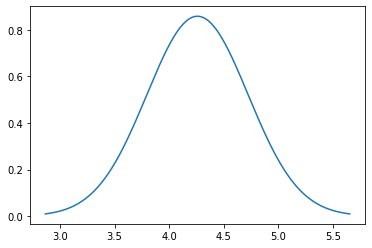

In [10]:
# calculate mean and varience
x, y = raw_data[..., :-1], raw_data[..., -1]
x = x[np.where(y=='Iris-versicolor'), 2].squeeze()
mu, sigma = x.mean(), x.std()
print("For P(X_petal_length | Y = 'Iris Versicolour'):")
print(f'mean = {mu:.6f}, std = {sigma:.6f}')
print("probability density function: ")

# plot pdf
from scipy import stats
plt.figure()
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()